#1-1

MNIST 데이터셋을 사용하여 간단한 VAE을 구현한 코드입니다.

코드를 실행시키고, 주석을 달아주세요.

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [3]:
#파라미터 지정
num_epochs = 50
batch_size = 100
learning_rate = 0.0002
img_size = 28 * 28
latent_dim = 20
hidden_size1 = 256
hidden_size2 = 512
hidden_size3 = 1024
dir_name = "VAE_results"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if not os.path.exists(dir_name):
    os.makedirs(dir_name)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
#데이터셋 다운로드 및 로드
MNIST_dataset = datasets.MNIST(root='../../data/',
                               train=True,
                               transform=transform,
                               download=True)

data_loader = torch.utils.data.DataLoader(dataset=MNIST_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [5]:
class Encoder(nn.Module): # 인코더 생성
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(img_size, hidden_size3)
        self.fc2 = nn.Linear(hidden_size3, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size1)
        self.fc_mean = nn.Linear(hidden_size1, latent_dim)
        self.fc_logvar = nn.Linear(hidden_size1, latent_dim) # 히든 레이어의 값을 분포의 평균과 분산으로 사용
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar


class Decoder(nn.Module): # 디코더 생성
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, img_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

encoder = Encoder().to(device)
decoder = Decoder().to(device)

In [6]:
def reparameterize(mean, logvar): # 인코더에서 구한 평균과 분산을 이용하여 확률 분포 생성
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mean + eps * std

def loss_function(recon_x, x, mean, logvar): # loss function 지정
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

In [7]:
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    train_loss = 0

    for images, _ in data_loader:
        images = images.view(-1, img_size).to(device)

        images = (images + 1) / 2

        optimizer.zero_grad()

        mean, logvar = encoder(images)
        z = reparameterize(mean, logvar)
        recon_images = decoder(z)

        loss = loss_function(recon_images, images, mean, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(data_loader.dataset)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

    with torch.no_grad():
        z = torch.randn(batch_size, latent_dim).to(device)
        sample = decoder(z).view(-1, 1, 28, 28)
        save_image(sample, os.path.join(dir_name, f'VAE_fake_image_{epoch + 1}.png'))

Epoch [1/50], Loss: 201.1327
Epoch [2/50], Loss: 150.0422
Epoch [3/50], Loss: 131.5085
Epoch [4/50], Loss: 124.4908
Epoch [5/50], Loss: 119.2770
Epoch [6/50], Loss: 115.5908
Epoch [7/50], Loss: 113.0017
Epoch [8/50], Loss: 111.1685
Epoch [9/50], Loss: 109.5147
Epoch [10/50], Loss: 108.1860
Epoch [11/50], Loss: 107.0226
Epoch [12/50], Loss: 106.0354
Epoch [13/50], Loss: 105.1870
Epoch [14/50], Loss: 104.5532
Epoch [15/50], Loss: 103.8889
Epoch [16/50], Loss: 103.2661
Epoch [17/50], Loss: 102.7470
Epoch [18/50], Loss: 102.2532
Epoch [19/50], Loss: 101.7905
Epoch [20/50], Loss: 101.3741
Epoch [21/50], Loss: 101.0382
Epoch [22/50], Loss: 100.5946
Epoch [23/50], Loss: 100.3200
Epoch [24/50], Loss: 100.0049
Epoch [25/50], Loss: 99.6847
Epoch [26/50], Loss: 99.4540
Epoch [27/50], Loss: 99.1667
Epoch [28/50], Loss: 98.9567
Epoch [29/50], Loss: 98.6833
Epoch [30/50], Loss: 98.4880
Epoch [31/50], Loss: 98.2797
Epoch [32/50], Loss: 98.0760
Epoch [33/50], Loss: 97.9047
Epoch [34/50], Loss: 97.7035

#1-2

아래 마크다운으로 VAE_fake_image_1.png와 VAE_fake_image_50.png를 함께 첨부해주세요.


### Image 1

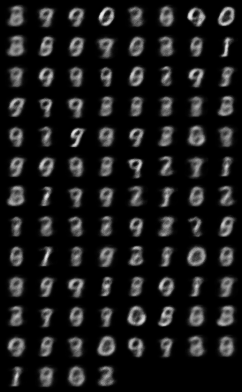


### Image 50

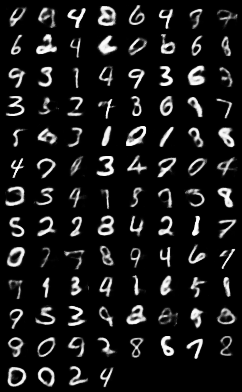